# 用于对n=24队列的三个层级+4个策略进行比较

In [1]:

from sklearn.metrics import roc_curve, auc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test


/home/longyh/miniforge3/envs/py310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# =========================
# 0) Paths (EDIT HERE)
# =========================
TNB_CSV = "/work/longyh/BY/processed/TNB/TNB_summary_by_unit.csv"  # 你的TNB汇总输出
CLINICAL_XLSX = "/work/longyh/BY/raw/1-s2.0-S0092867417311224-mmc2.xlsx"

# =========================
# 1) Helpers
# =========================
def bootstrap_auc_ci(y_true, y_score, n_boot=2000, seed=1):
    """
    Bootstrap percentile CI for AUC.
    Returns (auc_point, ci_low, ci_high).
    Skips resamples with only one class.
    """
    rng = np.random.default_rng(seed)
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    # point estimate
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_point = auc(fpr, tpr)

    boot_aucs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        ys = y_score[idx]
        if len(np.unique(yt)) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(yt, ys)
        boot_aucs.append(auc(fpr_b, tpr_b))

    if len(boot_aucs) < 50:
        # 太少说明样本太小或标签极度不均衡
        return auc_point, np.nan, np.nan

    ci_low, ci_high = np.quantile(boot_aucs, [0.025, 0.975])
    return auc_point, float(ci_low), float(ci_high)


def make_response_label(df, response_col="Response"):
    """
    RECIST二分类：CR/PR=1, SD/PD=0, NE剔除
    """
    df = df.copy()
    df = df[df[response_col].notna()]
    df[response_col] = df[response_col].astype(str).str.strip().str.upper()
    df = df[df[response_col] != "NE"].copy()

    response_map = {"CR": 1, "PR": 1, "SD": 0, "PD": 0}
    df["response_label"] = df[response_col].map(response_map)

    # 若出现异常类别，打印出来
    unknown = df.loc[df["response_label"].isna(), response_col].value_counts()
    if len(unknown) > 0:
        print("[WARN] Unmapped Response categories:\n", unknown)
        df = df.dropna(subset=["response_label"]).copy()

    df["response_label"] = df["response_label"].astype(int)
    return df


def pick_score_cols(summary_df, unit, which="unique"):
    """
    根据你的TNB汇总列名生成待评估的列。
    这里默认策略列：s1/s2/s3/s4 + unique/raw
    """
    suffix = "unique" if which == "unique" else "raw"
    cols = []
    for s in ["s1", "s2", "s3", "s4"]:
        c = f"{unit}_{s}_{suffix}"
        if c in summary_df.columns:
            cols.append(c)
    return cols


def plot_roc_for_scores(df, y_col, score_cols, title_prefix="", n_boot=2000, seed=1, summary_rows=None):
    """
    对一组score列，分别画ROC（每列一张图），并把AUC/CI写入summary_rows(list of dict)
    """
    for sc in score_cols:
        tmp = df[[y_col, sc]].dropna().copy()
        y = tmp[y_col].values.astype(int)
        x = tmp[sc].values.astype(float)

        if len(np.unique(y)) < 2 or len(tmp) < 8:
            print(f"[SKIP] {sc}: not enough samples or single-class.")
            continue

        auc_point, ci_low, ci_high = bootstrap_auc_ci(y, x, n_boot=n_boot, seed=seed)

        # quick direction check
        auc_rev, _, _ = bootstrap_auc_ci(y, -x, n_boot=500, seed=seed)
        suggest_flip = bool(auc_point < 0.5 and auc_rev > auc_point)

        # write summary
        if summary_rows is not None:
            summary_rows.append({
                "score_col": sc,
                "n": int(len(tmp)),
                "responders": int(y.sum()),
                "non_responders": int(len(y) - y.sum()),
                "auc": float(auc_point),
                "ci_low": float(ci_low) if not np.isnan(ci_low) else np.nan,
                "ci_high": float(ci_high) if not np.isnan(ci_high) else np.nan,
                "suggest_flip": suggest_flip,
            })

        # plot
        fpr, tpr, _ = roc_curve(y, x)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

        ci_text = "CI unavailable" if np.isnan(ci_low) else f"95%CI [{ci_low:.3f}, {ci_high:.3f}]"
        flip_text = " (maybe flip sign)" if suggest_flip else ""
        plt.title(f"{title_prefix}{sc}\nAUC={auc_point:.3f}, {ci_text}{flip_text}")
        plt.tight_layout()
        plt.show()

        print(f"{sc}: AUC={auc_point:.4f}, {ci_text}, n={len(tmp)}, responders={int(y.sum())}/{len(y)}")



In [5]:

# =========================
# 2) Load data
# =========================
summary = pd.read_csv(TNB_CSV, dtype=str)
clinical = pd.read_excel(CLINICAL_XLSX,skiprows=2)

# 统一ID类型
summary["sample"] = summary["sample"].astype(str).str.strip()
clinical["Patient"] = clinical["Patient"].astype(str).str.strip()

# summary里的数值列转成float（非数值会变NaN）
for c in summary.columns:
    if c in ["sample", "file"]:
        continue
    summary[c] = pd.to_numeric(summary[c], errors="coerce")

# clinical做响应标签
clinical2 = make_response_label(clinical, response_col="Response")

# 合并
merged = pd.merge(summary, clinical2, left_on="sample", right_on="Patient", how="inner")
print("Merged n =", len(merged))
print("Responders =", merged["response_label"].sum(), "/", len(merged))


Merged n = 22
Responders = 6 / 22


In [ ]:


# =========================
# 3) Optional: filter cohort
# =========================
# 你想只看Ipi-N就用这个；如果要全体，就注释掉这段
# COHORT = "Ipi-N"   # 改成 "Ipi-P" 或 None
# if COHORT is not None:
#     merged = merged[merged["Cohort"].astype(str).str.strip() == COHORT].copy()
#     print(f"After cohort filter ({COHORT}) n =", len(merged))
#     print("Responders =", merged["response_label"].sum(), "/", len(merged))




Unit: mutation, which=unique, cols=['mutation_s1_unique', 'mutation_s2_unique', 'mutation_s3_unique', 'mutation_s4_unique']


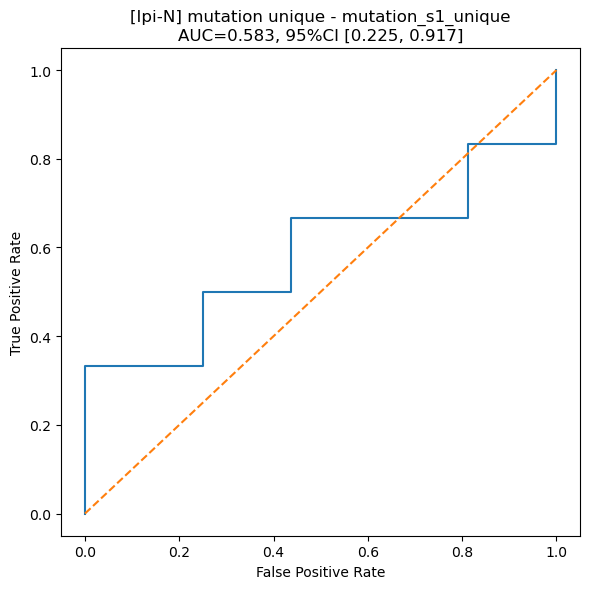

mutation_s1_unique: AUC=0.5833, 95%CI [0.225, 0.917], n=22, responders=6/22


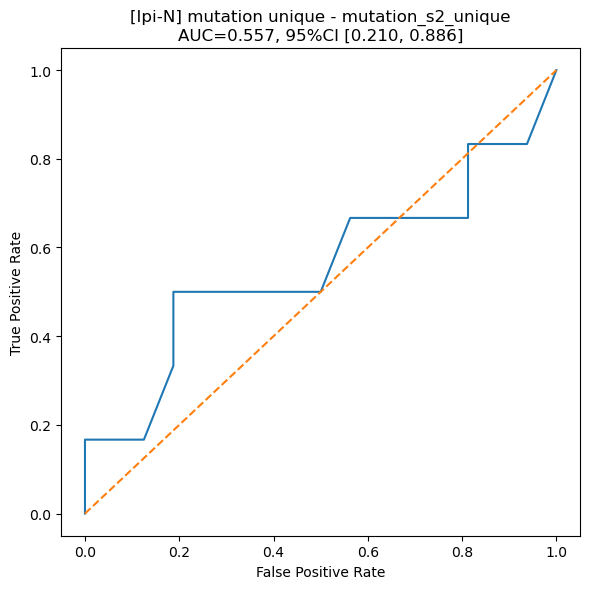

mutation_s2_unique: AUC=0.5573, 95%CI [0.210, 0.886], n=22, responders=6/22


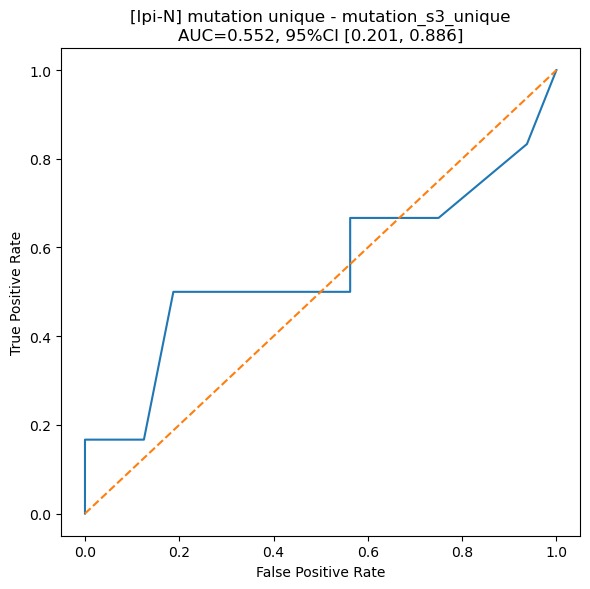

mutation_s3_unique: AUC=0.5521, 95%CI [0.201, 0.886], n=22, responders=6/22


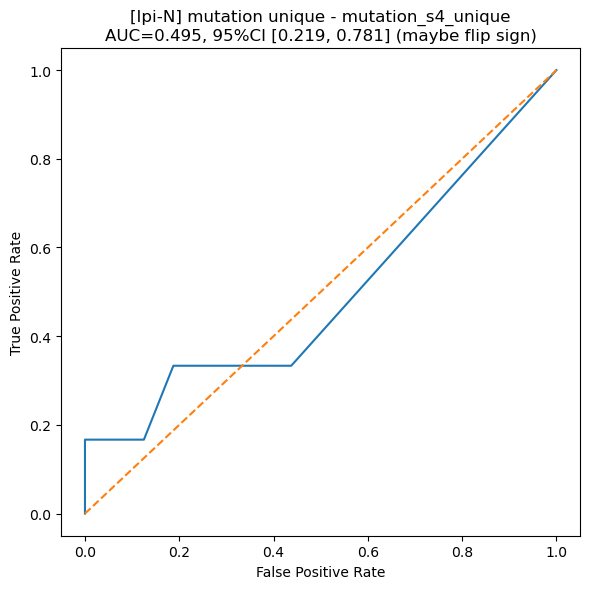

mutation_s4_unique: AUC=0.4948, 95%CI [0.219, 0.781], n=22, responders=6/22

Unit: peptide, which=unique, cols=['peptide_s1_unique', 'peptide_s2_unique', 'peptide_s3_unique', 'peptide_s4_unique']


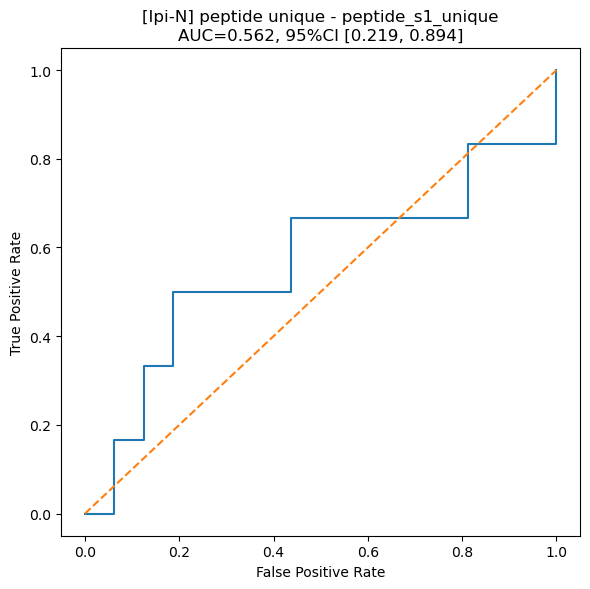

peptide_s1_unique: AUC=0.5625, 95%CI [0.219, 0.894], n=22, responders=6/22


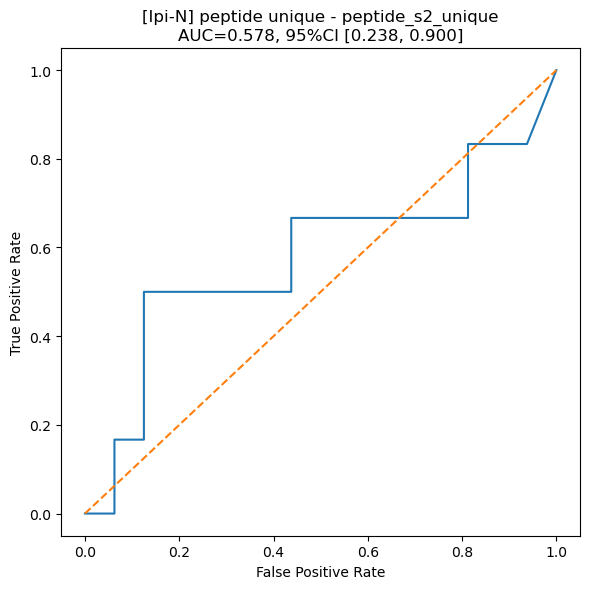

peptide_s2_unique: AUC=0.5781, 95%CI [0.238, 0.900], n=22, responders=6/22


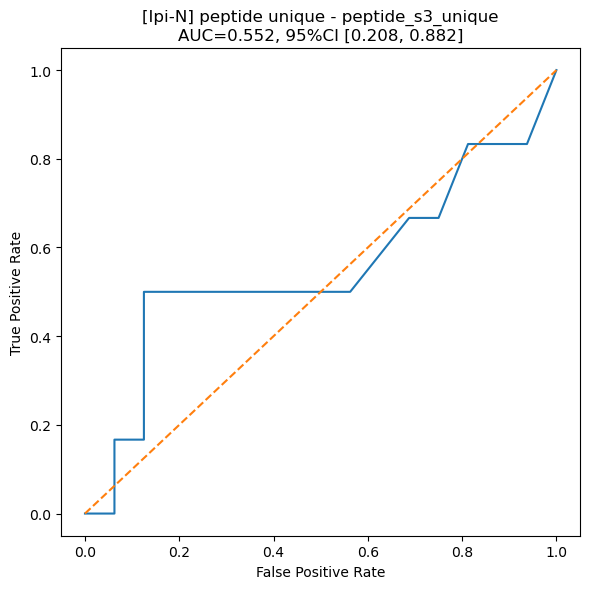

peptide_s3_unique: AUC=0.5521, 95%CI [0.208, 0.882], n=22, responders=6/22


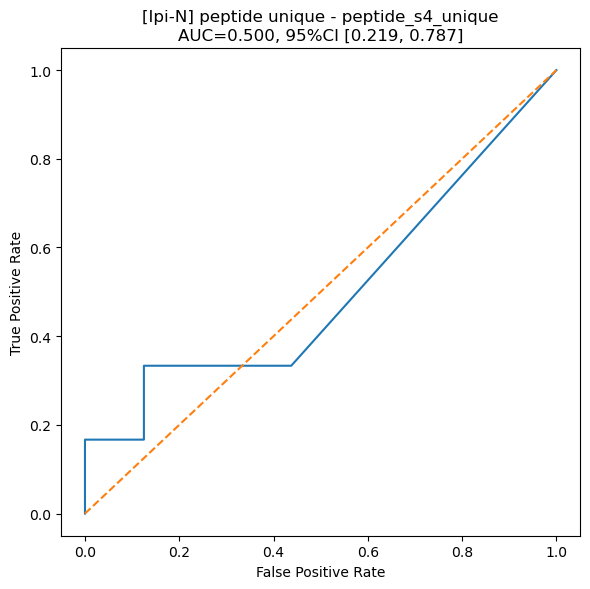

peptide_s4_unique: AUC=0.5000, 95%CI [0.219, 0.787], n=22, responders=6/22

Unit: hla_peptide, which=unique, cols=['hla_peptide_s1_unique', 'hla_peptide_s2_unique', 'hla_peptide_s3_unique', 'hla_peptide_s4_unique']


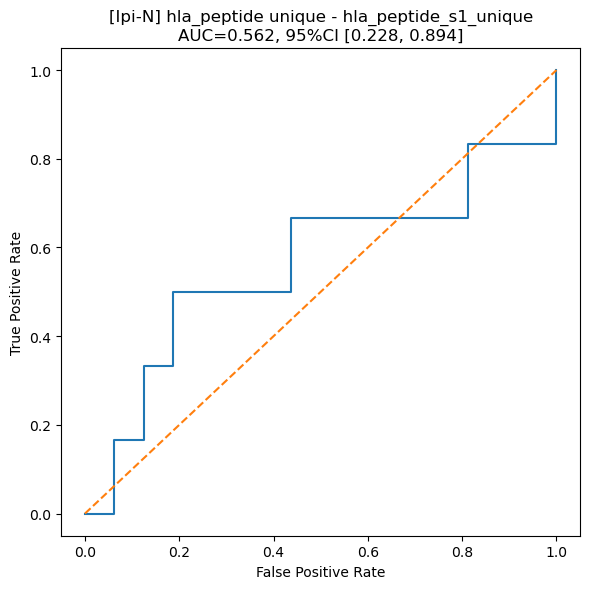

hla_peptide_s1_unique: AUC=0.5625, 95%CI [0.228, 0.894], n=22, responders=6/22


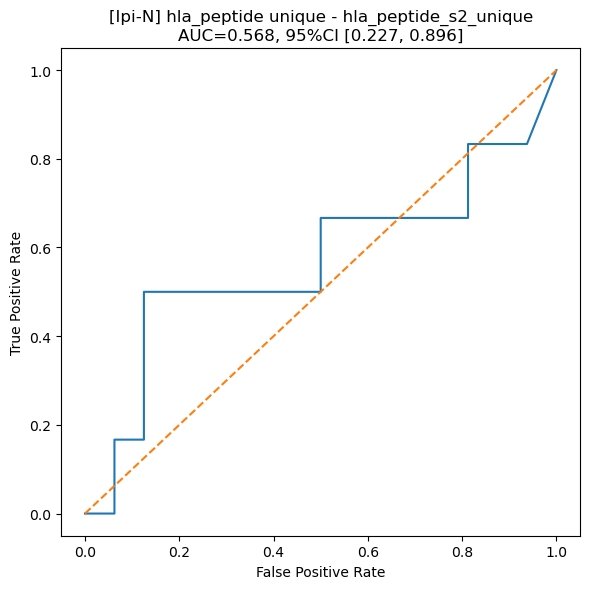

hla_peptide_s2_unique: AUC=0.5677, 95%CI [0.227, 0.896], n=22, responders=6/22


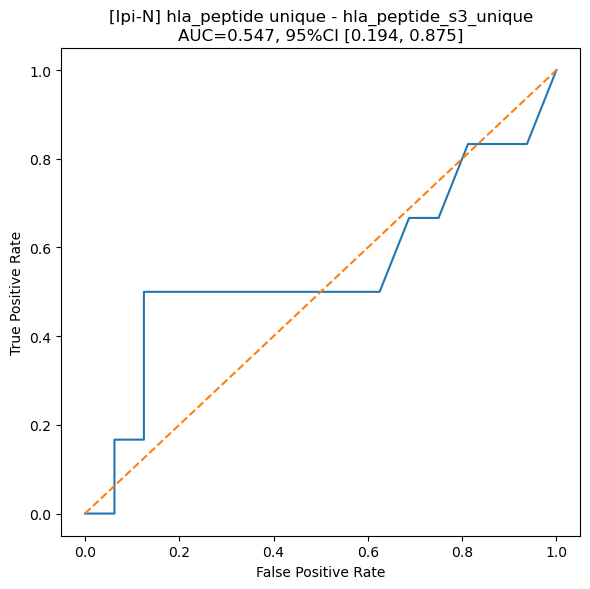

hla_peptide_s3_unique: AUC=0.5469, 95%CI [0.194, 0.875], n=22, responders=6/22


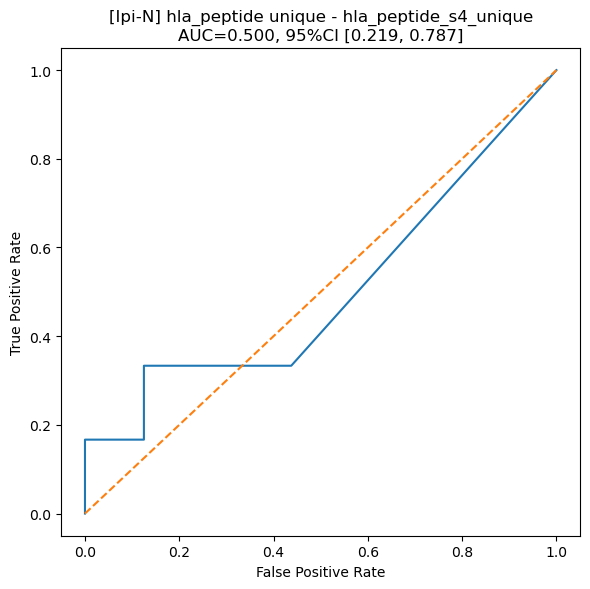

hla_peptide_s4_unique: AUC=0.5000, 95%CI [0.219, 0.787], n=22, responders=6/22


In [ ]:
COHORT_LABEL = "Ipi-N"

# =========================
# 4) ROC plots (by unit)
# =========================
units = ["mutation", "peptide", "hla_peptide"]

# 推荐先用unique（更不易被多HLA/滑窗放大）
WHICH = "unique"   # 或 "raw"
N_BOOT = 2000

roc_rows = []

for u in units:
    score_cols = pick_score_cols(merged, unit=u, which=WHICH)
    if not score_cols:
        continue

    plot_roc_for_scores(
        merged,
        y_col="response_label",
        score_cols=score_cols,
        title_prefix=f"[{COHORT_LABEL}] {u} {WHICH} - ",
        n_boot=N_BOOT,
        seed=1,
        summary_rows=roc_rows,
    )

roc_summary = pd.DataFrame(roc_rows).sort_values(["auc"], ascending=False)
roc_summary.to_csv("/work/longyh/BY/processed/TNB/roc_summary.csv", index=False)
print("Saved: roc_summary.csv")



/tmp/ipykernel_4076756/407236567.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["Non-response(0)", "Response(1)"])


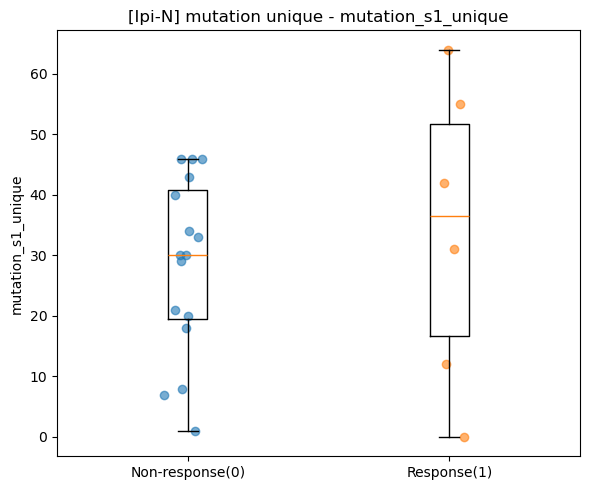

/tmp/ipykernel_4076756/407236567.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["Non-response(0)", "Response(1)"])


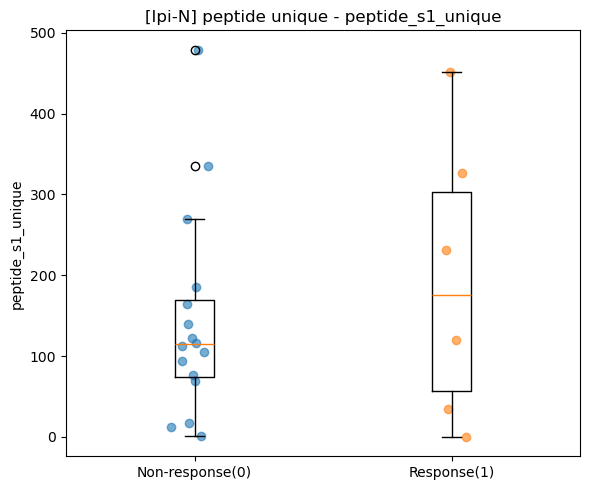

/tmp/ipykernel_4076756/407236567.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["Non-response(0)", "Response(1)"])


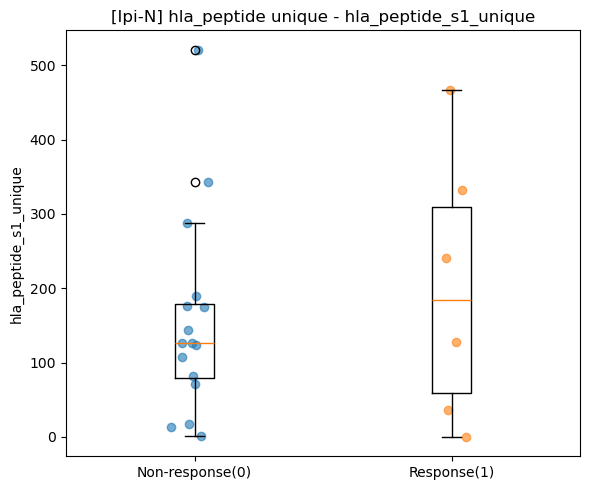

In [9]:

# =========================
# 5) Quick distribution sanity check (optional)
# =========================
# 先看策略1的分布最直观
for u in units:
    c = f"{u}_s1_{WHICH}"
    if c in merged.columns:
        plot_tnb_box(
            merged,
            "response_label",
            c,
            title=f"[{COHORT_LABEL}] {u} {WHICH} - {c}",
        )
    else:
        print("[WARN] missing column:", c)



In [10]:
# =========================
# 6) Identify time-to-event columns (PFS preferred, else OS)
# =========================
def find_time_event_cols(df):
    """
    Try to find PFS columns first; otherwise fall back to OS using:
      'Time to Death\n(weeks)' and 'Dead/Alive\n(Dead = True)'
    Returns (time_col, event_col, endpoint_name)
    """
    cols = list(df.columns)

    # candidate patterns for PFS (you may need to adapt to your real columns)
    pfs_time_candidates = [
        "PFS", "PFS (weeks)", "PFS weeks", "Time to Progression", "Time to Progression (weeks)",
        "Progression Free Survival", "Progression-free survival", "PFS_time"
    ]
    pfs_event_candidates = [
        "PFS event", "PFS_event", "Progressed", "Progression", "Progression event", "PFS_status"
    ]

    def _match_any(candidates):
        for cand in candidates:
            if cand in cols:
                return cand
        return None

    time_col = _match_any(pfs_time_candidates)
    event_col = _match_any(pfs_event_candidates)

    if time_col and event_col:
        return time_col, event_col, "PFS"

    # fallback to OS columns that you listed
    os_time = "Time to Death\n(weeks)" if "Time to Death\n(weeks)" in cols else None
    os_event = "Dead/Alive\n(Dead = True)" if "Dead/Alive\n(Dead = True)" in cols else None
    if os_time and os_event:
        return os_time, os_event, "OS"

    raise ValueError("No PFS/OS time-event columns found. Please specify column names manually.")


time_col, event_col, endpoint = find_time_event_cols(merged)
print("Using endpoint:", endpoint, "| time_col:", time_col, "| event_col:", event_col)

# normalize event column to 0/1
km_df = merged.copy()

# event might be True/False or strings; normalize robustly
def to_event01(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (bool, np.bool_)):
        return int(bool(x))
    s = str(x).strip().lower()
    if s in {"true", "1", "dead", "yes", "event"}:
        return 1
    if s in {"false", "0", "alive", "no", "censored", "none"}:
        return 0
    # try numeric
    try:
        v = int(float(s))
        return 1 if v != 0 else 0
    except Exception:
        return np.nan

km_df[event_col] = km_df[event_col].apply(to_event01)
km_df[time_col] = pd.to_numeric(km_df[time_col], errors="coerce")

# drop missing time/event
km_df = km_df.dropna(subset=[time_col, event_col]).copy()
km_df[event_col] = km_df[event_col].astype(int)

print("KM usable n =", len(km_df), "| events =", km_df[event_col].sum(), "/", len(km_df))


Using endpoint: OS | time_col: Time to Death
(weeks) | event_col: Dead/Alive
(Dead = True)
KM usable n = 22 | events = 15 / 22


In [ ]:
# =========================
# 7) KM + log-rank + Cox for a given score column
# =========================
def plot_km_and_cox(df, time_col, event_col, score_col, title_prefix="", summary_rows=None):
    tmp = df[[time_col, event_col, score_col]].dropna().copy()
    if len(tmp) < 10:
        print(f"[SKIP] {score_col}: too few samples.")
        return

    median_val = tmp[score_col].median()
    tmp["group"] = np.where(tmp[score_col] > median_val, "High", "Low")

    g1 = tmp[tmp["group"] == "High"]
    g0 = tmp[tmp["group"] == "Low"]
    if len(g1) < 3 or len(g0) < 3:
        print(f"[SKIP] {score_col}: group too small (High={len(g1)}, Low={len(g0)}).")
        return

    lr = logrank_test(
        g1[time_col], g0[time_col],
        event_observed_A=g1[event_col], event_observed_B=g0[event_col]
    )

    # KM plot
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(6.5, 5.5))
    kmf.fit(g0[time_col], event_observed=g0[event_col], label=f"Low (n={len(g0)})")
    ax = kmf.plot(ci_show=True)
    kmf.fit(g1[time_col], event_observed=g1[event_col], label=f"High (n={len(g1)})")
    kmf.plot(ax=ax, ci_show=True)

    plt.xlabel(f"Time (weeks)")
    plt.ylabel("Survival probability")
    plt.title(f"{title_prefix}{score_col}\nlog-rank p={lr.p_value:.3g} (median={median_val:.3g})")
    plt.tight_layout()
    plt.show()

    # Cox (continuous, log1p)
    cox_df = tmp[[time_col, event_col, score_col]].copy()
    cox_df["x"] = np.log1p(cox_df[score_col].astype(float))

    cph = CoxPHFitter()
    cph.fit(cox_df[[time_col, event_col, "x"]], duration_col=time_col, event_col=event_col)
    summ = cph.summary.loc["x", ["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]]

    hr = float(summ["exp(coef)"])
    lo = float(summ["exp(coef) lower 95%"])
    hi = float(summ["exp(coef) upper 95%"])
    p = float(summ["p"])

    print(f"{score_col} | Cox(log1p): HR={hr:.3f} [{lo:.3f}, {hi:.3f}] p={p:.3g} | log-rank p={lr.p_value:.3g}")

    if summary_rows is not None:
        summary_rows.append({
            "score_col": score_col,
            "n": int(len(tmp)),
            "events": int(tmp[event_col].sum()),
            "endpoint": str(time_col),
            "median_cut": float(median_val),
            "logrank_p": float(lr.p_value),
            "cox_hr_log1p": hr,
            "cox_ci_low": lo,
            "cox_ci_high": hi,
            "cox_p": p,
        })


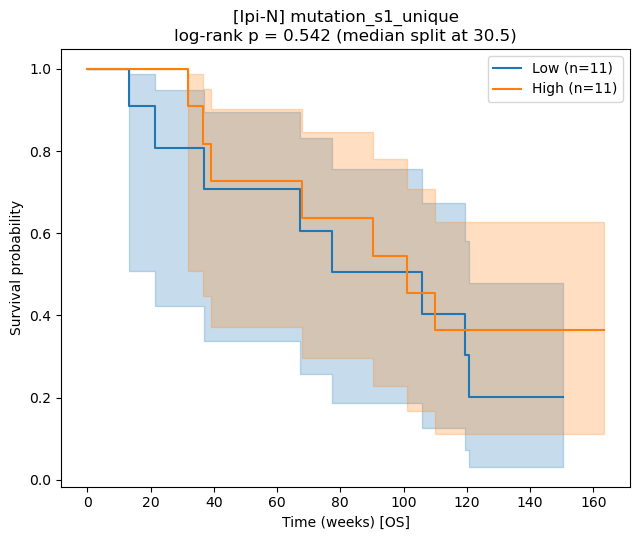

mutation_s1_unique | Cox(log1p): HR=1.207 [0.681, 2.141] p=0.519 | log-rank p=0.542


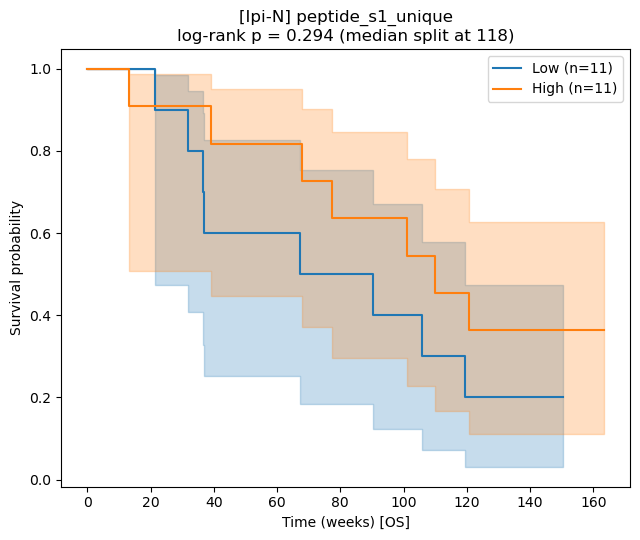

peptide_s1_unique | Cox(log1p): HR=1.094 [0.764, 1.567] p=0.624 | log-rank p=0.294


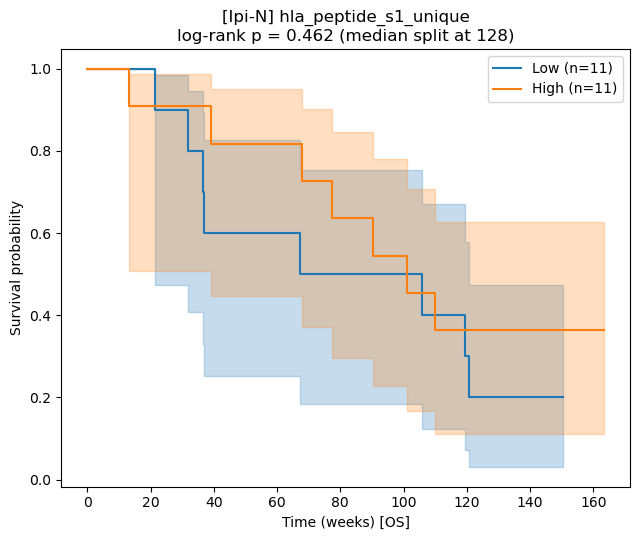

hla_peptide_s1_unique | Cox(log1p): HR=1.110 [0.771, 1.598] p=0.575 | log-rank p=0.462


In [ ]:

# =========================
# 8) Run for selected TNB columns
# =========================
# 可以先挑最关键的：策略1（S1）在三个计数单位下
WHICH = "unique"  # 和ROC保持一致
km_rows = []

targets = [
    f"mutation_s1_{WHICH}",
    f"peptide_s1_{WHICH}",
    f"hla_peptide_s1_{WHICH}",
]

for col in targets:
    if col in km_df.columns:
        plot_km_and_cox(
            km_df, time_col, event_col, col,
            title_prefix=f"[{COHORT_LABEL}] ",
            summary_rows=km_rows
        )

km_summary = pd.DataFrame(km_rows)
km_summary.to_csv("/work/longyh/BY/processed/TNB/km_cox_summary.csv", index=False)
print("Saved: km_cox_summary.csv")

